# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [2]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import heapq
import time
import itertools
%matplotlib inline

Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


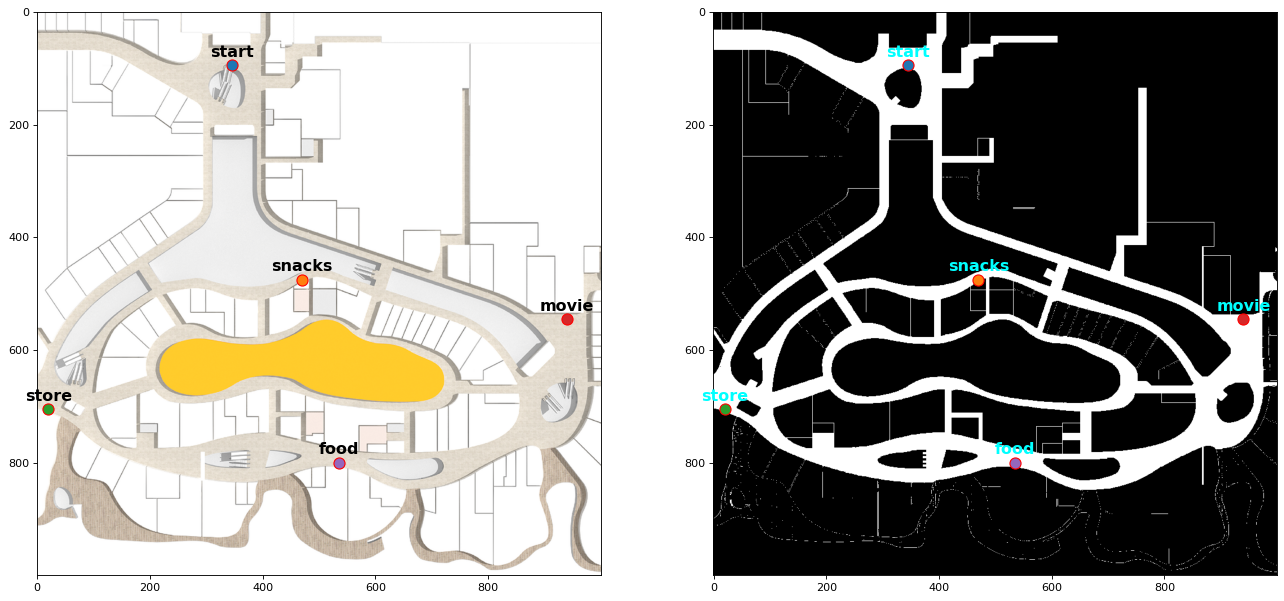

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [3]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

In [13]:
# Map resolution (constant)
MAP_RES = 0.2  # Each cell represents a 0.2m x 0.2m square in reality

# A* Helper functions
# Directions (8-connected neighbors)
DIRECTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

# Heuristic function (Euclidean distance)
def heuristic(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

# A* Algorithm
def a_star(start, goal, grid_map):
    rows, cols = grid_map.shape
    open_list = []
    closed_list = set()
    came_from = {}
    g_cost = {start: 0}
    
    # Using a priority queue (heap) for open list
    heapq.heappush(open_list, (heuristic(start, goal), 0, start))
    
    while open_list:
        _, current_cost, current = heapq.heappop(open_list)

        # If we reach the goal
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1], g_cost[goal]

        closed_list.add(current)

        # Explore neighbors
        for direction in DIRECTIONS:
            neighbor = (current[0] + direction[0], current[1] + direction[1])

            # Check if within bounds and not an obstacle
            if not (0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols):
                continue
            if grid_map[neighbor[0], neighbor[1]] == 0:  # Occupied space
                continue

            tentative_g_cost = current_cost + 0.2 if direction in [(-1, 0), (1, 0), (0, -1), (0, 1)] else 0.282

            # If this neighbor has not been visited or we've found a better path
            if neighbor not in closed_list:  # Prevent revisiting nodes in closed_list
                if neighbor not in g_cost or tentative_g_cost < g_cost[neighbor]:
                    came_from[neighbor] = current
                    g_cost[neighbor] = tentative_g_cost
                    f_cost = tentative_g_cost + heuristic(neighbor, goal)
                    heapq.heappush(open_list, (f_cost, tentative_g_cost, neighbor))

    return None, None  # No path found

# Function to calculate the total path length by summing the distances between consecutive points
def calculate_total_distance(path):
    total_distance = 0
    for i in range(1, len(path)):
        # Calculate the distance between each pair of consecutive points
        x1, y1 = path[i-1]
        x2, y2 = path[i]
        
        # Euclidean distance between consecutive points
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        total_distance += distance

    return total_distance * MAP_RES  # Convert to meters

# Function to plot the planned path on the map
def plot_path(path, grid_map, locations):
    plt.figure(figsize=(10, 10), dpi=80)
    plt.imshow(grid_map, cmap='gray', origin='lower')  # 'lower' to match the path orientation
    plot_locations(locations, color='cyan')
    x, y = zip(*path)
    plt.plot(y, x, marker='o', color='yellow', markersize=4, label="Planned Path")
    plt.legend()
    plt.show()
# 计算路径中每一对相邻节点之间的距离并累加
def calculate_total_distance(path):
    total_distance = 0
    for i in range(1, len(path)):
        # 获取相邻两个点的坐标
        x1, y1 = path[i-1]
        x2, y2 = path[i]
        
        # 计算相邻两个点之间的欧几里得距离
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        total_distance += distance
    
    # 如果路径是用真实坐标表示的，可以转换成实际的单位
    total_distance_in_meters = total_distance * 0.2  # 根据地图分辨率调整（0.2m x 0.2m的格子）
    
    return total_distance_in_meters
# Function to calculate the distance matrix between locations
def calculate_distance_matrix(locations, grid_map):
    distance_matrix = np.zeros((len(locations), len(locations)))

    # Iterate over each pair of locations
    for i in range(len(locations)):
        for j in range(i + 1, len(locations)):  # Only calculate once (i, j) and use symmetry
            start_loc = tuple(locations[locations_order[i]])
            goal_loc = tuple(locations[locations_order[j]])

            # Run A* algorithm for each pair of locations
            path, _ = a_star(start_loc, goal_loc, grid_map)
            if path:
                distance = calculate_total_distance(path)
                distance_matrix[i][j] = distance
                distance_matrix[j][i] = distance  # Symmetric matrix
            else:
                distance_matrix[i][j] = float('inf')
                distance_matrix[j][i] = float('inf')

    return distance_matrix
# Custom Heuristic Function (Weighted Euclidean with obstacle consideration)
def heuristic(a, b, weight=1.0):
    return weight * np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

# Bidirectional A* Algorithm
def bidirectional_a_star(start, goal, grid_map):
    rows, cols = grid_map.shape
    open_list_fwd, open_list_bwd = [], []
    closed_fwd, closed_bwd = set(), set()
    came_from_fwd, came_from_bwd = {}, {}
    g_cost_fwd, g_cost_bwd = {start: 0}, {goal: 0}

    heapq.heappush(open_list_fwd, (heuristic(start, goal), 0, start))
    heapq.heappush(open_list_bwd, (heuristic(goal, start), 0, goal))

    meeting_node = None

    while open_list_fwd and open_list_bwd:
        # Forward Search
        _, cost_fwd, current_fwd = heapq.heappop(open_list_fwd)
        closed_fwd.add(current_fwd)

        if current_fwd in closed_bwd:
            meeting_node = current_fwd
            break

        for direction in DIRECTIONS:
            neighbor = (current_fwd[0] + direction[0], current_fwd[1] + direction[1])
            if not (0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols):
                continue
            if grid_map[neighbor[0], neighbor[1]] == 0:
                continue

            tentative_g_cost = cost_fwd + (0.2 if direction in [(-1, 0), (1, 0), (0, -1), (0, 1)] else 0.282)
            if neighbor not in g_cost_fwd or tentative_g_cost < g_cost_fwd[neighbor]:
                came_from_fwd[neighbor] = current_fwd
                g_cost_fwd[neighbor] = tentative_g_cost
                heapq.heappush(open_list_fwd,
                               (tentative_g_cost + heuristic(neighbor, goal), tentative_g_cost, neighbor))

        # Backward Search
        _, cost_bwd, current_bwd = heapq.heappop(open_list_bwd)
        closed_bwd.add(current_bwd)

        if current_bwd in closed_fwd:
            meeting_node = current_bwd
            break

        for direction in DIRECTIONS:
            neighbor = (current_bwd[0] + direction[0], current_bwd[1] + direction[1])
            if not (0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols):
                continue
            if grid_map[neighbor[0], neighbor[1]] == 0:
                continue

            tentative_g_cost = cost_bwd + (0.2 if direction in [(-1, 0), (1, 0), (0, -1), (0, 1)] else 0.282)
            if neighbor not in g_cost_bwd or tentative_g_cost < g_cost_bwd[neighbor]:
                came_from_bwd[neighbor] = current_bwd
                g_cost_bwd[neighbor] = tentative_g_cost
                heapq.heappush(open_list_bwd,
                               (tentative_g_cost + heuristic(neighbor, start), tentative_g_cost, neighbor))

    if meeting_node is None:
        return None, None

    path_fwd = []
    current = meeting_node
    while current in came_from_fwd:
        path_fwd.append(current)
        current = came_from_fwd[current]
    path_fwd.append(start)

    path_bwd = []
    current = meeting_node
    while current in came_from_bwd:
        path_bwd.append(current)
        current = came_from_bwd[current]
    path_bwd.append(goal)

    return path_fwd[::-1] + path_bwd[1:], g_cost_fwd[meeting_node] + g_cost_bwd[meeting_node]
def calculate_distance_matrix1(locations, grid_map):
    distance_matrix = np.zeros((len(locations), len(locations)))
    for i in range(len(locations)):
        for j in range(i + 1, len(locations)):
            start_loc = tuple(locations[locations_order[i]])
            goal_loc = tuple(locations[locations_order[j]])
            path, _ = bidirectional_a_star(start_loc, goal_loc, grid_map)
            if path:
                distance = calculate_total_distance(path)
                distance_matrix[i][j] = distance
                distance_matrix[j][i] = distance
            else:
                distance_matrix[i][j] = float('inf')
                distance_matrix[j][i] = float('inf')
    return distance_matrix

In [14]:
locations_order = ['start', 'snacks', 'store', 'movie', 'food']
# Compute the distance matrix
distance_matrix = calculate_distance_matrix(locations, grid_map)
# Print the 5x5 distance matrix in a table format
print("Distance matrix (in meters):")
print("From/To  start  snacks  store  movie  food")
for i in range(len(locations_order)):
    row = [locations_order[i]] + [f"{distance_matrix[i][j]:.2f}" for j in range(len(locations_order))]
    print("\t".join(row))

Distance matrix (in meters):
From/To  start  snacks  store  movie  food
start	0.00	173.49	172.11	207.49	254.98
snacks	173.49	0.00	136.02	149.40	141.43
store	172.11	136.02	0.00	291.58	147.09
movie	207.49	149.40	291.58	0.00	212.41
food	254.98	141.43	147.09	212.41	0.00


In [15]:
# Compute the distance matrix
locations_order = ['start', 'snacks', 'store', 'movie', 'food']
print("Distance matrix (in meters):")
distance_matrix = calculate_distance_matrix1(locations, grid_map)
print("From/To  start  snacks  store  movie  food")
for i in range(len(locations_order)):
    row = [locations_order[i]] + [f"{distance_matrix[i][j]:.2f}" for j in range(len(locations_order))]
    print("\t".join(row))

Distance matrix (in meters):
From/To  start  snacks  store  movie  food
start	0.00	153.07	162.98	180.88	229.33
snacks	153.07	0.00	121.80	114.73	135.35
store	162.98	121.80	0.00	255.78	114.67
movie	180.88	114.73	255.78	0.00	116.48
food	229.33	135.35	114.67	116.48	0.00


## Task 2

In [6]:
# Locations and distance table (given)
locations_order = ['start', 'snacks', 'store', 'movie', 'food']
distance_table = {
    ('start', 'start'): 0.00, ('start', 'snacks'): 153.07, ('start', 'store'): 162.98, ('start', 'movie'): 180.49, ('start', 'food'): 229.33,
    ('snacks', 'start'): 162.98, ('snacks', 'snacks'): 0.00, ('snacks', 'store'):  121.80 , ('snacks', 'movie'): 114.73, ('snacks', 'food'): 135.35,
    ('store', 'start'): 162.98, ('store', 'snacks'): 121.80, ('store', 'store'): 0.00, ('store', 'movie'): 255.78, ('store', 'food'): 114.67,
    ('movie', 'start'): 180.88, ('movie', 'snacks'): 114.73, ('movie', 'store'): 255.78, ('movie', 'movie'): 0.00, ('movie', 'food'): 116.48,
    ('food', 'start'): 229.33 , ('food', 'snacks'): 135.35, ('food', 'store'): 114.67, ('food', 'movie'): 212.41, ('food', 'food'): 0.00
}
locations_without_start = ['snacks', 'store', 'movie', 'food']
permutations = itertools.permutations(locations_without_start)

Brute Force Method

In [7]:
# Calculate the distance for each permutation
min_distance = float('inf')
optimal_route = []

for perm in permutations:
    # Add start and end locations
    route = ['start'] + list(perm) + ['start']
    distance = 0
    
    # Calculate the total distance of this route
    for i in range(len(route) - 1):
        distance += distance_table[(route[i], route[i+1])]
    
    # Update the optimal route if a shorter distance is found
    if distance < min_distance:
        min_distance = distance
        optimal_route = route

print("Optimal route using Brute Force:", optimal_route)
print("Total distance using Brute Force:", min_distance)


Optimal route using Brute Force: ['start', 'snacks', 'movie', 'food', 'store', 'start']
Total distance using Brute Force: 661.9300000000001


greedy

In [8]:
# Greedy algorithm implementation (fixed)
def greedy_algorithm(start, locations, distance_table):
    route = [start]
    visited = set([start])
    total_distance = 0
    
    current_location = start
    
    while len(visited) < len(locations) + 1:  # Ensure we visit all locations, including the start
        nearest_location = None
        min_distance = float('inf')
        
        # Find the nearest unvisited location
        for location in locations:
            if location not in visited:
                dist = distance_table[(current_location, location)]
                if dist < min_distance:
                    nearest_location = location
                    min_distance = dist
        
        # Move to the nearest location
        route.append(nearest_location)
        visited.add(nearest_location)
        total_distance += min_distance
        current_location = nearest_location
    
    # Add the start location to complete the cycle
    total_distance += distance_table[(current_location, start)]
    route.append(start)
    
    return route, total_distance

# Run greedy algorithm with the corrected code
route, total_distance = greedy_algorithm('start', locations_without_start, distance_table)
print("Optimal route using Greedy Algorithm:", route)
print("Total distance using Greedy Algorithm:", total_distance)

Optimal route using Greedy Algorithm: ['start', 'snacks', 'movie', 'food', 'store', 'start']
Total distance using Greedy Algorithm: 661.9300000000001


Visualization

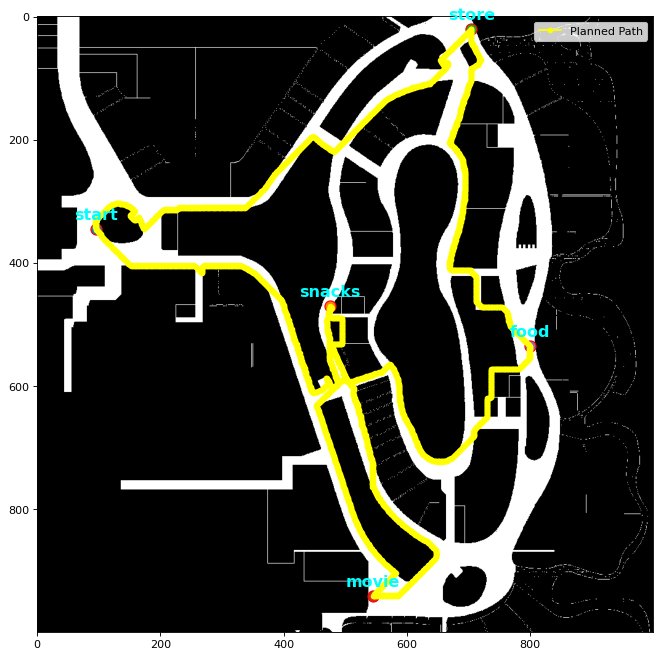

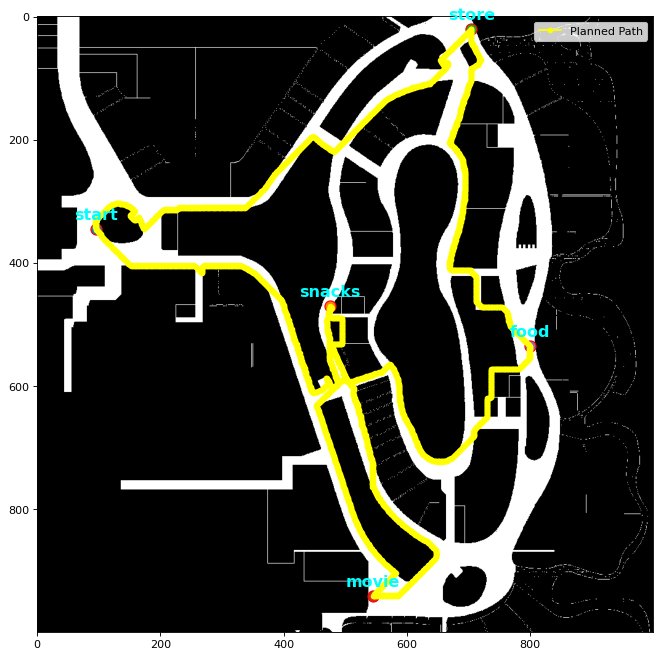

Total distance: 661.93 meters


In [9]:
# Function to plot the actual path obtained from A* on the map
def plot_route_on_map(route, grid_map, locations):
    plt.figure(figsize=(10, 10), dpi=80)
    plt.imshow(grid_map, cmap='gray')
    location11 = {'start': [95, 345], 'snacks': [475, 470], 'store': [705, 20], 'movie': [545, 940], 'food': [800, 535]}
    plot_locations(location11, color='cyan')  # Plot locations as cyan points
    
    full_path = []
    for i in range(len(route) - 1):
        start_loc = tuple(locations[route[i]])  # Convert list to tuple
        goal_loc = tuple(locations[route[i + 1]])  # Convert list to tuple
        
        # Run A* to get the actual path between each pair of locations
        path, _ = a_star(start_loc, goal_loc, grid_map)
        if path:
            full_path.extend(path[1:])  # Exclude the first point to avoid duplicates
    
    # Plot the full path from A* (not direct lines between locations)
    x, y = zip(*full_path)  # Extract x and y coordinates of the full path
    plt.plot(y, x, marker='o', color='yellow', markersize=4, label="Planned Path")
    
    plt.legend()
    plt.show()

# Now plot for both solutions
plot_route_on_map(optimal_route, grid_map, locations)  # For Brute Force solution
plot_route_on_map(route, grid_map, locations)  # For Greedy Algorithm solution

# Print total distance based on the computed value
print(f"Total distance: {min_distance if 'min_distance' in locals() else total_distance:.2f} meters")
